In [1]:
import numpy as np
import pandas as pd
from sympy import symbols, Function, Eq, dsolve

In [2]:
# Configuraciones iniciales
np.random.seed(42)  # Para reproducibilidad
g = 9.81  # Gravedad en m/s^2
num_samples = 5000  # Número de trayectorias

# Definir símbolos para sympy
t = symbols("t")  # Tiempo
vx, vy = Function("vx")(t), Function("vy")(t)  # Velocidades
m, c, g = symbols("m c g")  # Parámetros
x, y = symbols("x y")  # Posiciones

# Ecuaciones diferenciales
a_x = Eq(vx.diff(t), -(c / m) * vx)
a_y = Eq(vy.diff(t), -g - (c / m) * vy)

# Solución de las ecuaciones
sol_vx = dsolve(a_x)
sol_vy = dsolve(a_y)

# Generación de valores aleatorios
velocidades_iniciales = np.random.uniform(10, 100, num_samples)  # m/s
angulos = np.random.uniform(10, 80, num_samples)  # grados
masas = np.random.uniform(0.5, 10, num_samples)  # kg
constantes_resistencia = np.random.uniform(0.1, 1.0, num_samples)  # kg/m
# Convertir soluciones en funciones para evaluar
vx_func = sol_vx.rhs
vy_func = sol_vy.rhs

In [3]:
def calcular_trayectoria(v0, theta, m_val, c_val, dt=0.01, max_time=10):
    theta_rad = np.radians(theta)  # Convertir ángulo a radianes
    vx0 = v0 * np.cos(theta_rad)  # Velocidad inicial en x
    vy0 = v0 * np.sin(theta_rad)  # Velocidad inicial en y

    # Reemplazar constantes en sympy
    vx_t = vx_func.subs({c: c_val, m: m_val}).subs("C1", vx0)
    vy_t = vy_func.subs({c: c_val, m: m_val, g: 9.81}).subs("C1", vy0)

    # Inicializar posiciones
    x, y = 0, 0
    trayectoria = []

    for t_val in np.arange(0, max_time, dt):
        # Evaluar velocidades
        vx_eval = vx_t.subs(t, t_val).evalf()
        vy_eval = vy_t.subs(t, t_val).evalf()

        # Validar valores de las velocidades
        if vx_eval < 0 or vy_eval < 0:
            pass

        # Actualizar posiciones
        x += vx_eval * dt
        y += vy_eval * dt

        # Guardar trayectoria
        trayectoria.append((x, y))

        # Detener si toca el suelo
        if y < 0:
            break

    return trayectoria

In [4]:
# Generación del dataset
data = []
for v0, theta, m_val, c_val in zip(
    velocidades_iniciales, angulos, masas, constantes_resistencia
):
    trayectoria = calcular_trayectoria(v0, theta, m_val, c_val)
    for punto in trayectoria:
        data.append([v0, theta, m_val, c_val, punto[0], punto[1]])
        if len(data) >= num_samples:
            break  # Detener cuando se alcance el número deseado de registros

# Convertir a DataFrame
columnas = [
    "velocidad_inicial",
    "angulo",
    "masa",
    "constante_resistencia",
    "pos_x",
    "pos_y",
]
datos = pd.DataFrame(data[:num_samples], columns=columnas)  # Asegurar 5000 registros

# Guardar en CSV
datos.to_csv("trayectorias_proyectil.csv", index=False)
print("Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.")


Generación de datos completada. Guardado en 'trayectorias_proyectil.csv'.


[(0.353553390593274, -1.60844660940673)]


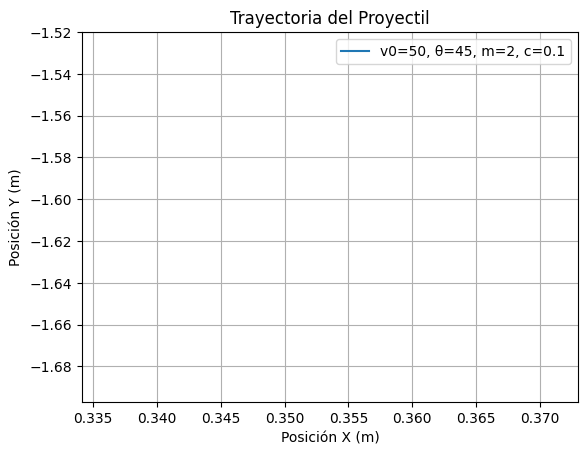

In [5]:
import matplotlib.pyplot as plt

# Parámetros iniciales de prueba
v0 = 50  # Velocidad inicial en m/s
theta = 45  # Ángulo en grados
m_val = 2  # Masa en kg
c_val = 0.1  # Resistencia del aire en kg/m

# Calcular la trayectoria
trayectoria = calcular_trayectoria(v0, theta, m_val, c_val, dt=0.01, max_time=10)
print(trayectoria)

# Separar posiciones x e y
x_vals = [pos[0] for pos in trayectoria]
y_vals = [pos[1] for pos in trayectoria]

# Graficar la trayectoria
plt.plot(x_vals, y_vals, label=f"v0={v0}, θ={theta}, m={m_val}, c={c_val}")
plt.xlabel("Posición X (m)")
plt.ylabel("Posición Y (m)")
plt.title("Trayectoria del Proyectil")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

datos = pd.read_csv("trayectorias_proyectil.csv")
# Generar características derivadas
datos["cos_angulo"] = np.cos(np.radians(datos["angulo"]))
datos["sin_angulo"] = np.sin(np.radians(datos["angulo"]))

# Seleccionar características y normalizar
X = datos[
    ["velocidad_inicial", "cos_angulo", "sin_angulo", "masa", "constante_resistencia"]
].values
# X = datos[["velocidad_inicial", "angulo", "masa", "constante_resistencia"]].values
y = datos[["pos_x", "pos_y"]].values

# Escalar datos
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)


# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear el modelo mejorado

model = Sequential(
    [
        Dense(256, input_dim=X_train.shape[1], activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(2, activation="linear"),
    ]
)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error", metrics=["mae"]
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - relative_error

print(f"Error relativo promedio: {relative_error:.2f}%")
print(f"Precisión del modelo: {accuracy:.2f}%")


Epoch 1/1500


/home/mrtopo/Documents/Universidad/2024-2/inteligentesII/intelligent-II-neuronal-networks/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1344 - mae: 0.8249 - val_loss: 0.0735 - val_mae: 0.1965
Epoch 2/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7643 - mae: 0.6773 - val_loss: 0.0709 - val_mae: 0.2122
Epoch 3/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5898 - mae: 0.5921 - val_loss: 0.0672 - val_mae: 0.2062
Epoch 4/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4896 - mae: 0.5371 - val_loss: 0.0519 - val_mae: 0.1855
Epoch 5/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3908 - mae: 0.4858 - val_loss: 0.0499 - val_mae: 0.1853
Epoch 6/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3351 - mae: 0.4490 - val_loss: 0.0542 - val_mae: 0.1859
Epoch 7/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3006 - mae: 0.4266 - val_loss: 0.0660 - val_mae: 0.2052
Epoch 8/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2530 - mae: 0.3948 - val_loss: 0.0654 - val_mae: 0.1997
Epoch 9/1500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

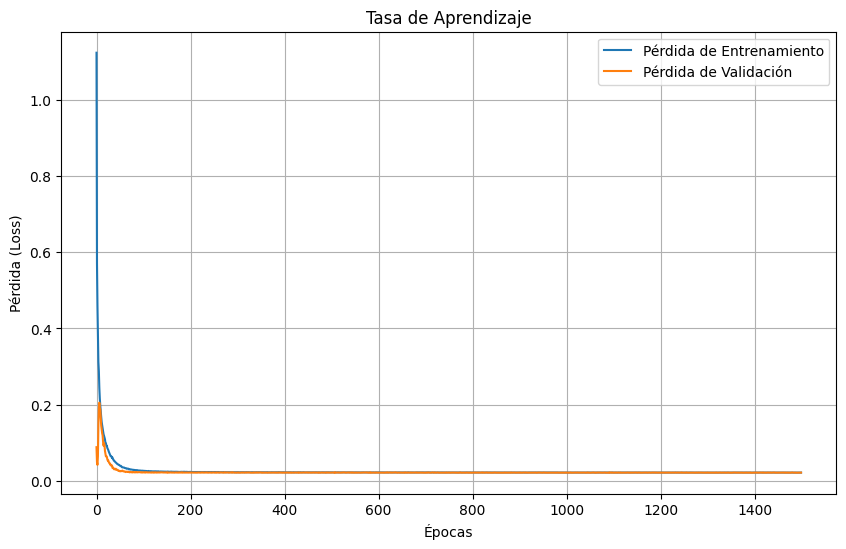

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Error relativo promedio: 118.74%
Precisión del modelo: -18.74%


In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.title("Tasa de Aprendizaje")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Calcular precisión relativa
y_pred = model.predict(X_test)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - relative_error

print(f"Error relativo promedio: {relative_error:.2f}%")
print(f"Precisión del modelo: {accuracy:.2f}%")